In [4]:
%%time

from adlfs import AzureBlobFileSystem


import time



import json
import pandas
import pandas as pd
from tqdm import tqdm

from common.schemas.pyarrow_schema import tagging_schema
from common.storage.azure_file_storage import AzureFileStorageAdapter
from common.captioning.azure_descriptions import AzureCaption
from common.schemas.pyarrow_schema import schema

tqdm.pandas(desc="Progress")
file_system: AzureBlobFileSystem = AzureFileStorageAdapter('data').get_file_storage()

from common.data_frame_functions.functions import Functions

functions: Functions = Functions()

caption: AzureCaption = AzureCaption(file_system)

CPU times: total: 46.9 ms
Wall time: 40.2 ms


In [5]:
%%time

curated_data = pandas.read_parquet("data/parquet/back.parquet", engine="pyarrow", filesystem=file_system)

curated_data.set_index("id", inplace=True, drop=False)

filtered = curated_data.loc[curated_data["accept"] == True, schema.names]

filtered.dropna(inplace=True)

display(filtered.shape)

display(filtered)

(19172, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
1013bdt,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
105mekt,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
105qvgl,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
105rpcj,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]
105styc,105styc,AmIhotAF,Gizzygirl127,Low key… still bangable?,smiling woman sitting on couch with remote con...,6d555943be4fbc21ff92417c6f582298,/r/AmIhotAF/comments/105styc/low_key_still_ban...,https://i.redd.it/aiaxxoz9uoaa1.jpg,105styc.jpg,data/image/105styc.jpg,SexyDiffusion,True,True,True,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13ccd23,13ccd23,bathandbodyworks,poppy3chicken,Scrub turned orange?,there is a tube of body scrub sitting on a table,5d5da65cdb5fc71ee482664c9fff6a29,/r/bathandbodyworks/comments/13ccd23/scrub_tur...,https://i.redd.it/pp8cnprgarya1.jpg,13ccd23.jpg,data/image/13ccd23.jpg,CandleDiffusion,True,True,True,[]
13d1gsm,13d1gsm,bathandbodyworks,twelfthcapaldi,Haul from yesterday’s EDP/EDT sale 😊,bottles of bath products are lined up on a cou...,7c1ba0ab114cc39c85bbb2d7109af6ab,/r/bathandbodyworks/comments/13d1gsm/haul_from...,https://i.redd.it/2ndvcjlk2wya1.jpg,13d1gsm.jpg,data/image/13d1gsm.jpg,CandleDiffusion,True,True,True,[]
13d2hsf,13d2hsf,bathandbodyworks,alesieoksap,Ice Cream Shop Collection?,someone holding a cup of ice cream in their hand,c6788074138175c661fc652bd7630e33,/r/bathandbodyworks/comments/13d2hsf/ice_cream...,https://i.redd.it/uhwamoq99wya1.jpg,13d2hsf.jpg,data/image/13d2hsf.jpg,CandleDiffusion,True,True,True,[]


CPU times: total: 938 ms
Wall time: 1.53 s


In [6]:
%%time

sources = [
	{"name": "CityDiffusion", "data": ["CityPorn"]},
	{"name": "NatureDiffusion", "data": ["EarthPorn"]},
	{"name": "CosmicDiffusion", "data": ["spaceporn"]},
	{"name": "ITAPDiffusion", "data": ["itookapicture"]},
	{"name": "MemeDiffusion", "data": ["memes"]},
	{"name": "TTTDiffusion", "data": ["trippinthroughtime"]},
	{"name": "WallStreetDiffusion", "data": ["wallstreetbets"]},
	{"name": "SexyDiffusion", "data": ["selfies", "Amicute", "amihot", "AmIhotAF", "HotGirlNextDoor", "sexygirls", "PrettyGirls", "gentlemanboners", "hotofficegirls", "tightdresses", "DLAH"]},
	{"name": "FatSquirrelDiffusion", "data": ["fatsquirrelhate"]},
	{"name": "CelebrityDiffusion", "data": ["celebrities"]},
	{"name": "OldLadyDiffusion", "data": ["oldladiesbakingpies"]},
	{"name": "SWFPetite", "data": ["sfwpetite"]},
	{"name": "SFWMilfs", "data": ["cougars_and_milfs_sfw"]},
	{"name": "RedHeadDiffusion", "data": ["SFWRedheads"]},
	{"name": "NextDoorGirlsDiffusion", "data": ["SFWNextDoorGirls"]},
	{"name": "SexyAsianDiffusion", "data": ["realasians", "KoreanHotties", "prettyasiangirls", "AsianOfficeLady", "AsianInvasion"]},
	{"name": "MildlyPenisDiffusion", "data": ["mildlypenis"]},
	{"name": "CandleDiffusion", "data": ["bathandbodyworks"] },
]
sources_df = pd.DataFrame.from_records(sources)

CPU times: total: 0 ns
Wall time: 85.4 ms


In [7]:
filtered['model'] = filtered.apply(lambda x: functions.add_source(x, sources), axis=1)
foo = filtered.loc[filtered['model'] != ""]
foo.dropna()
filtered = foo
display(filtered)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
1013bdt,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
105mekt,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
105qvgl,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
105rpcj,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]
105styc,105styc,AmIhotAF,Gizzygirl127,Low key… still bangable?,smiling woman sitting on couch with remote con...,6d555943be4fbc21ff92417c6f582298,/r/AmIhotAF/comments/105styc/low_key_still_ban...,https://i.redd.it/aiaxxoz9uoaa1.jpg,105styc.jpg,data/image/105styc.jpg,SexyDiffusion,True,True,True,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13ccd23,13ccd23,bathandbodyworks,poppy3chicken,Scrub turned orange?,there is a tube of body scrub sitting on a table,5d5da65cdb5fc71ee482664c9fff6a29,/r/bathandbodyworks/comments/13ccd23/scrub_tur...,https://i.redd.it/pp8cnprgarya1.jpg,13ccd23.jpg,data/image/13ccd23.jpg,CandleDiffusion,True,True,True,[]
13d1gsm,13d1gsm,bathandbodyworks,twelfthcapaldi,Haul from yesterday’s EDP/EDT sale 😊,bottles of bath products are lined up on a cou...,7c1ba0ab114cc39c85bbb2d7109af6ab,/r/bathandbodyworks/comments/13d1gsm/haul_from...,https://i.redd.it/2ndvcjlk2wya1.jpg,13d1gsm.jpg,data/image/13d1gsm.jpg,CandleDiffusion,True,True,True,[]
13d2hsf,13d2hsf,bathandbodyworks,alesieoksap,Ice Cream Shop Collection?,someone holding a cup of ice cream in their hand,c6788074138175c661fc652bd7630e33,/r/bathandbodyworks/comments/13d2hsf/ice_cream...,https://i.redd.it/uhwamoq99wya1.jpg,13d2hsf.jpg,data/image/13d2hsf.jpg,CandleDiffusion,True,True,True,[]


<Axes: title={'center': 'Subreddits with most posts'}, xlabel='subreddit'>

CPU times: total: 1.88 s
Wall time: 4.42 s


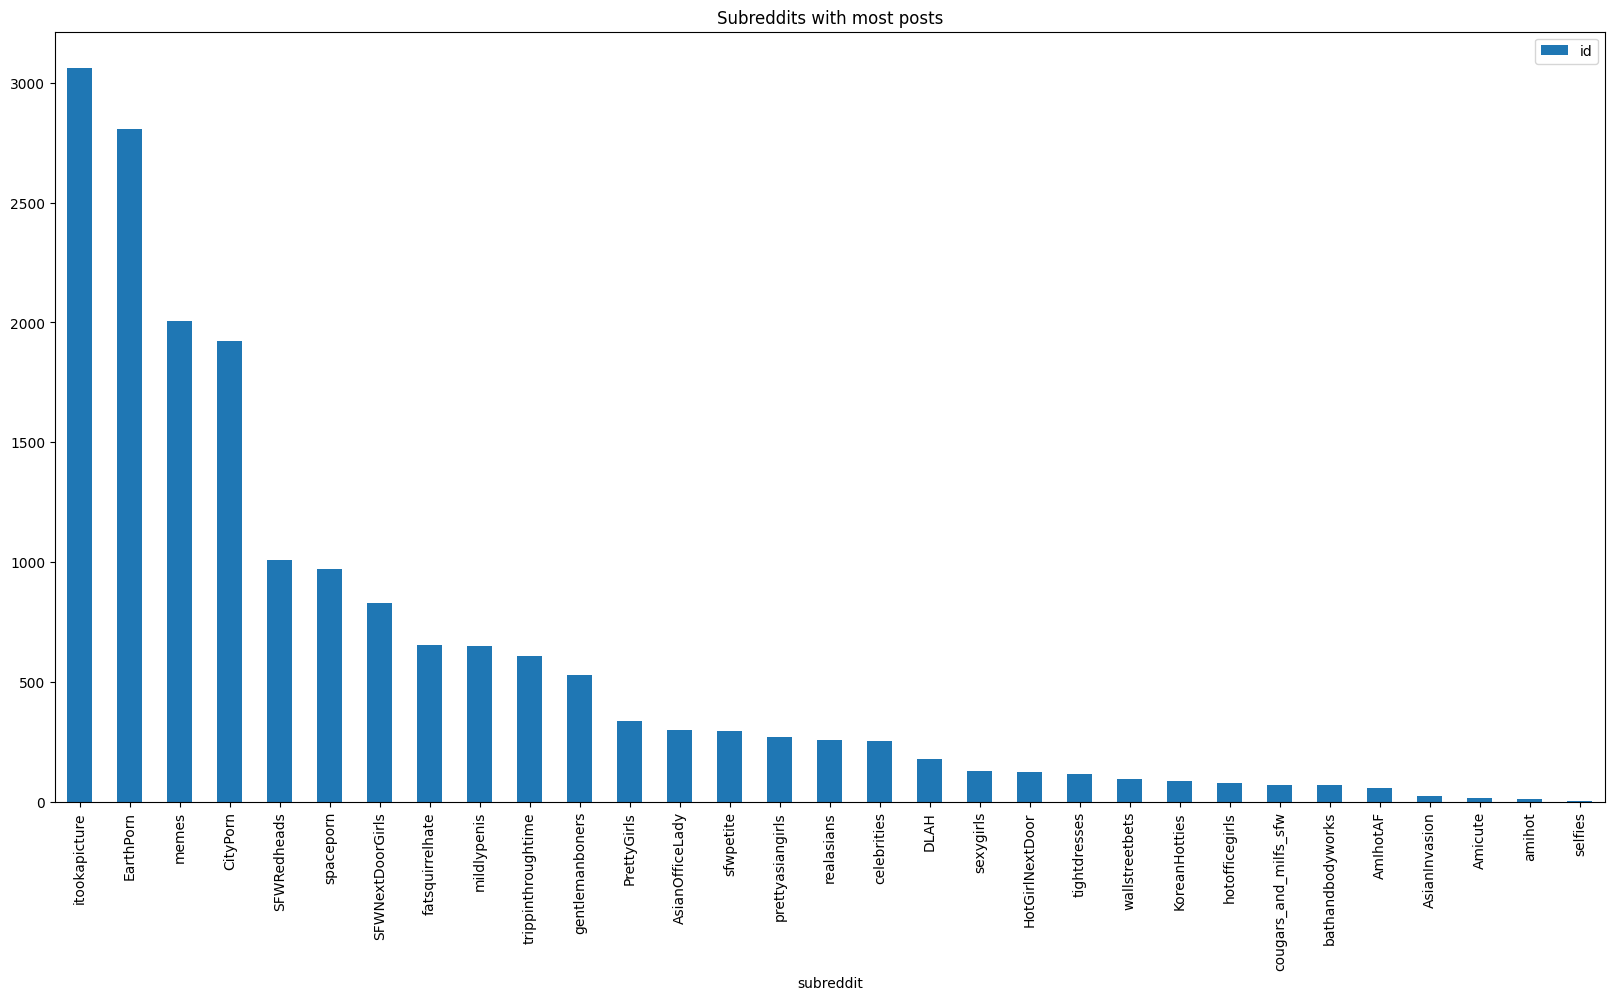

In [8]:
%%time

group = filtered[["id", "subreddit"]].groupby("subreddit").count().sort_values(by="id", ascending=False)
plot = group.plot.bar(figsize=(20, 10), title="Subreddits with most posts", legend=True)
display(plot)

<Axes: title={'center': 'Models with most images'}, xlabel='model'>

CPU times: total: 250 ms
Wall time: 320 ms


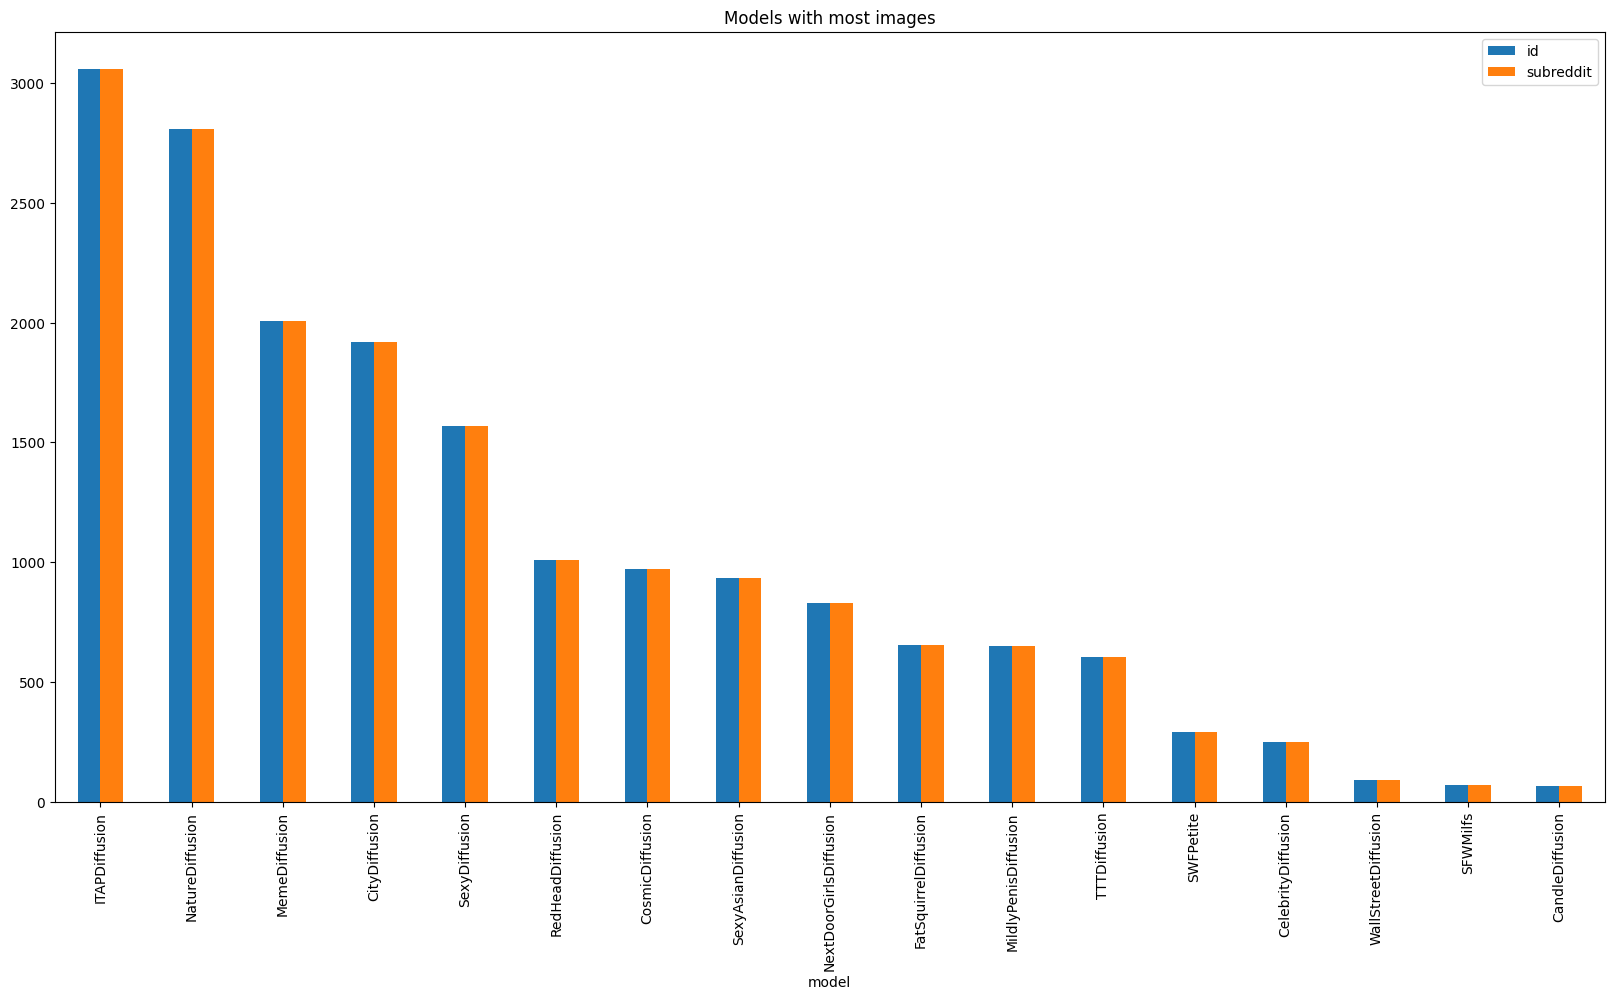

In [9]:
%%time

group = filtered[["id", "model", "subreddit"]].groupby(["model"]).count().sort_values(by="id", ascending=False)
plot_1 = group.plot.bar(figsize=(20, 10), title="Models with most images", legend=True)
display(plot_1)

In [10]:
bar = filtered.loc[(filtered["model"] == "SexyDiffusion") | (filtered["model"] == "SexyAsianDiffusion") | (filtered['model'] == "NextDoorGirlDiffusion") | (filtered['model'] == 'RedHeadDiffusion')]
dropped = bar.dropna(inplace=True)
display(bar.shape)
display(bar)
bar = filtered

C:\Users\AJ Stangl\AppData\Local\Temp\ipykernel_10684\2660330951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped = bar.dropna(inplace=True)


(3513, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
1013bdt,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
105mekt,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
105qvgl,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
105rpcj,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]
105styc,105styc,AmIhotAF,Gizzygirl127,Low key… still bangable?,smiling woman sitting on couch with remote con...,6d555943be4fbc21ff92417c6f582298,/r/AmIhotAF/comments/105styc/low_key_still_ban...,https://i.redd.it/aiaxxoz9uoaa1.jpg,105styc.jpg,data/image/105styc.jpg,SexyDiffusion,True,True,True,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13d24g6,13d24g6,DLAH,ThisActuator3213,College Grad,araffe woman in white dress standing on a porc...,1ae080b3c41a5c1998866f3812bbedc2,/r/DLAH/comments/13d24g6/college_grad/,https://i.redd.it/9gosudq9puya1.jpg,13d24g6.jpg,data/image/13d24g6.jpg,SexyDiffusion,True,True,True,[]
13d6beh,13d6beh,DLAH,Thin_Data_2134,DLAH,two women in green dresses posing for a pictur...,554832995493f72e24f5f875f23a7f14,/r/DLAH/comments/13d6beh/dlah/,https://i.redd.it/7el120jfywya1.jpg,13d6beh.jpg,data/image/13d6beh.jpg,SexyDiffusion,True,True,True,[]
13d8iiw,13d8iiw,DLAH,7Saints,Garden beauty,arafed woman in a black dress squatting in fro...,f673b58fc846ce993fde34bd5bd37b1a,/r/DLAH/comments/13d8iiw/garden_beauty/,https://i.redd.it/1puiw2vvcxya1.jpg,13d8iiw.jpg,data/image/13d8iiw.jpg,SexyDiffusion,True,True,True,[]


In [ ]:
%%time

from common.captioning.azure_descriptions import AzureCaption
records = bar.to_dict(orient="records")
current_captions = [item.replace('\n', '') for item in file_system.ls("data/caption")]
i = 0
for elem in records:
	i += 1
	path = elem['path']
	remote_path = file_system.url(path)
	if f'data/caption/{elem["id"]}.json' not in current_captions:
		display(f'Processing {elem["id"]} -- {i}/{len(records)}', clear=True)
		caption: AzureCaption = AzureCaption(file_system)
		output = caption.image_analysis(remote_path)
		time.sleep(12)
		json_result = output.json_result
		if json_result is None:
			display(f'Error with {elem["id"]} -- Empty Result -- {i}/{len(records)}', clear=True)
			continue
		try:
			if json.loads(json_result).get('error'):
				display(f'Error with {elem["id"]} -- Error: {json.loads(json_result).get("error")} -- {i}/{len(records)}', clear=True)
				continue
			handle = open('temp.json', 'w', encoding='utf-8')
			handle.write(json_result)
			handle.close()
			display(f'Uploading {elem["id"]} -- {i}/{len(records)}', clear=True)
			file_system.upload('temp.json', f'data/caption/{elem["id"]}.json')
		except Exception as e:
			display(f'Error with {elem["id"]} -- Error: {e} -- {i}/{len(records)}', clear=True)
			continue
	else:
		display(f'Skipping {elem["id"]} -- Already Processed -- {i}/{len(records)}', clear=True)
		continue

'Processing 11jpnbr -- 1044/17794'